# **Práctico 3 y 4 (parte 5): De palabras a números**

### Tabla de Contenidos
1. [Consigna](#1.-Consigna)
2. [Inicialización del entorno](#2.-Inicialización-del-entorno)
3. [Carga de datos](#3.-Carga-de-datos)
4. [Limpieza de datos](#4.-Limpieza-de-datos)
5. [Selección de las columnas de interés](#5.-Selección-de-las-columnas-de-interés)
6. [Vectorización](#6.-Vectorización)
7. [Inspección del resultado de la vectorización](#7.-Inspección-del-resultado-de-la-vectorización)
8. [División y normalización de los datos](#8.-División-y-normalización-de-los-datos)
9. [Predicción usando árboles de decisión](#9.-Predicción-usando-árboles-de-decisión)
10. [Predicción usando Naive Bayes](#10.-Predicción-usando-Naive-Bayes)
11. [Exploración de hiperparámetros de CountVectorizer](#11.-Exploración-de-hiperparámetros-de-CountVectorizer)
12. [Predicción modificando los parámetros del proceso de vectorización](#12.-Predicción-modificando-los-parámetros-del-proceso-de-vectorización)
13. [Conclusiones](#13.-Conclusiones)


## 1. Consigna

Los algoritmos de aprendizaje automático trabajan con espacios vectoriales (es decir, con muchos números). Entonces al trabajar con Procesamiento de Lenguaje Natural se plantea la cuestión de cómo representar texto con números. Hay muchas maneras de hacer esto y es un campo que sigue evolucionando con el tiempo. Una opción muy básica es asignarle a cada palabra que aparece en nuestro dataset un número según el orden en el que aparecen. Luego, una oración es un vector de índices de esas palabras. Pero esto tiene varios problemas. Entre ellos, los algoritmos de aprendizaje automático también requieren que los vectores tengan una longitud fija, con lo cual hay que recortar la oración o agregarle ceros al final (es decir, hacer padding). Por eso un enfoque clásico para representar texto es el Bag Of Words: un vector de bits del tamaño de todo nuestro vocabulario que tiene un uno si la palabra está en la oración y un 0 si no está. Este enfoque también se conoce como One Hot Vector. 

Referencias: 
1. https://es.wikipedia.org/wiki/Modelo_bolsa_de_palabras 

2. https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction

3. https://towardsdatascience.com/the-magic-behind-embedding-models-part-1-974d539f21fd

Para la implementación podrían usar Spacy, como se usó para la tokenización. Sin embargo creo que va a ser más sencillo para uds usar la libreria CountVectorizer que implementa el Bag Of Words de forma eficiente considerando que es una representación esparsa. Esta sugerencia es porque uds ya vienen usando sklearn.

Con el objetivo de visualizar lo que hace CountVectorizer vamos a explorar sus hiperparámetros min_df, max_df y ngram-range. Observar cómo cambia el tamaño del vector.

Los parámetros min_df y max_df que se corresponden con min y max document frequency. Ámbos toman valores entre 0 y 1 y estipulan el rango de frecuencia de aparición de una palabra dentro de un documento que vamos a aceptar. Es decir, si min_df es 0.005, todas las palabras que representen menos de un 0,5% de las palabras totales serán descartadas. Por el otro lado, si max_df es 0.35, todas las palabras que representen más de un 35% del total de palabras serán descartadas. Visualizar las palabras que serían descartadas dentro de este rango y describir cómo son. 

El parámetro ngram_range calcula la frecuencia de ngramas. Resulta útil para descubrir frases o expresiones comunes (además de las palabras comunes). Además, en combinación con el parámetro "analyzer" se pueden usar como ngramas de palabras o de caracteres.

Referencias: 

4. https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

5. De palabras a vectores por DOT CVS: https://www.youtube.com/watch?v=Tg1MjMIVArc


NOTA: Como el tamaño del vector (es decir, el vocabulario) debe ser igual para el entrenamiento como para el test y el dev, tenemos que vectorizar todos los dataset de la misma forma. 

## 2. Inicialización del entorno

In [ ]:
#Librerías 
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
from ast import literal_eval
import re
import itertools

# Para gráficos
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from yellowbrick.text import FreqDistVisualizer

# Para dividir el dataset en train  y test
from sklearn.model_selection import train_test_split
from sklearn import model_selection

# Para tratamiento de texto
from sklearn.feature_extraction.text import CountVectorizer

# Para el cálculo de tf y tf–idf 
from sklearn.feature_extraction.text import TfidfTransformer

# Algoritmo del Árbol de Decisión
from sklearn.tree import (DecisionTreeClassifier, plot_tree)

# Para utilizar Naive-Bayes para la clasificación
from sklearn.naive_bayes import MultinomialNB

# Para utilizar el algoritmo del gradiente descendiente
#from sklearn.linear_model import SGDClassifier

# Para calcular métricas
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, classification_report, plot_roc_curve, confusion_matrix) 

# Para vectorizar los tokens
from sklearn.feature_extraction.text import CountVectorizer

# Utiles
from utiles import basic_metrics
from utiles import plot_cm
from utiles import plot_roc_pr

# Colores
BLUE   = '#5DADE2'
RED    = '#ff7043'
ORANGE = '#F5B041'
GREEN  = '#58D68D'
YELLOW = '#F4D03F'

# Plot axes y legends parambs
plt.rcParams["axes.labelweight"]   = "bold"
plt.rcParams["axes.titleweight"]   = "bold"
plt.rcParams["legend.shadow"]      = True
plt.rcParams["figure.titleweight"] = "bold"

# Classes
classes = ['0 - Negativa', '1 - Positiva']

#### **Funciones**

In [ ]:
# Informa los reultados obtenidos mediante la matriz de confusión (heatmap) y classification_report
def informar_resultados(y_test, pred_y, y_test_pred_prob, Title=''):
    print (classification_report(y_test, pred_y), '\n\n')
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, xticklabels=classes, yticklabels=classes, annot=True, fmt="d", cmap='Greens', linecolor='black', linewidths=1, square=True, cbar=False);
    plt.title(Title + " - Matriz de Confusión")
    plt.ylabel('Real')
    plt.xlabel('Predicción')
    plt.show()
    plot_roc_pr(y_test,  pred_y, y_test_pred_prob, Title= Title + ' - ROC PR',  x_text=0.4, y_text=0.2, size_text=12, size=(12,5), ms=15, colorR=ORANGE, colorP=GREEN, label=None);

## 3. Carga de datos 

El archivo **yup_curated_data.csv** se genera a partir del archivo yup_messages_preprocessed.csv y datadump-20150801-20171219.csv y se cura para aplicar sobre el mismo técnicas de procesamiento del lenguaje natural. La curación de dicho archivo fue realizada en la notebook [Practico_3y4_part_2y3_preparacion](https://github.com/giannipablo/MentoriaDiploDatos2020/blob/master/Practico_3y4_part_2y3_preparacion.ipynb)

In [ ]:
# Desde Colab
#from google.colab import files   
#uploaded = files.upload()

In [ ]:
# Desde el entorno local
filename = 'yup_curated_data.csv'
datos_curados = pd.read_csv(os.path.join('..', 'dataset', filename))

#### Dimensiones del dataset *datos curados*.

In [ ]:
print ('\nDimensiones del dataset\n')
print ('Filas: {}'.format(datos_curados.shape[0]))
print ('Columnas: {}'.format(datos_curados.shape[1]))


Dimensiones del dataset

Filas: 17429
Columnas: 22


## 4. Limpieza de datos

#### **Remoción de las sesiones con pocos turnos del estudiante o del tutor**

Cuando las sesiones cuenten con menos de 3 turnos del estudiante o del tutor se considera que el intercambio no es significativo por lo que se remueven dichas sesiones. 

In [ ]:
n_short_sessions = len(datos_curados[(datos_curados.n_msg_tutor < 3) | (datos_curados.n_msg_student < 3)])
datos_curados = datos_curados.drop(datos_curados[(datos_curados.n_msg_tutor < 3) | (datos_curados.n_msg_student < 3)].index)

print('\nDel dataset datos curados se remueven en total {} sesiones con menos de 3 turnos del estudiante o del tutor\n'.format(n_short_sessions))


Del dataset datos curados se remueven en total 1124 sesiones con menos de 3 turnos del estudiante o del tutor



#### **Remoción de las sesiones con la columna de tokens del estudiante o del tutor nula**

Se remueven aquellos diálogos sin información en las columnas de tokens del tutor o del estudiante.

In [ ]:
n_null_token_tutor = datos_curados['tokens_tutor'].isnull().sum()
n_null_token_student = datos_curados['tokens_student'].isnull().sum()
datos_curados = datos_curados.dropna(subset=['tokens_tutor','tokens_student'])
print('\nSe remueven {} sesiones sin tokens del tutor'.format(n_null_token_tutor))
print('\nSe remueven {} sesiones sin tokens del estudiante'.format(n_null_token_student))


print ('\nDimensiones del dataset\n')
print ('Filas: {}'.format(datos_curados.shape[0]))
print ('Columnas: {}'.format(datos_curados.shape[1]))


Se remueven 0 sesiones sin tokens del tutor

Se remueven 0 sesiones sin tokens del estudiante

Dimensiones del dataset

Filas: 16305
Columnas: 22


#### **Unificación de las expresiones algebraicas bajo el tag math**

Debido a que los sesiones corresponden a diálogos que contienen consultas sobre química, física o matemática, los mismos pueden contener fórmulas matemáticas. Por lo tanto, se decide unificar los unigramas que contienen al menos un dígito y al menos un operador algebraico bajo el tag **math** usando una expresión regular.

In [ ]:
datos_curados['tokens_tutor'] = datos_curados.tokens_tutor.apply(lambda x: literal_eval(x))
datos_curados['tokens_student'] = datos_curados.tokens_student.apply(lambda x: literal_eval(x))

# Utilizamos expresiones regulares para unificar los unigramas bajo el tag <math>

r = re.compile('((?=.*[0-9])(?=.*[%\/\(\)\^\\\+\-\*\=]))^.*')
datos_curados['tokens_tutor'] = datos_curados.tokens_tutor.apply(lambda x: ['<math>' if r.match(w) else w for w in x])
datos_curados['tokens_student'] = datos_curados.tokens_student.apply(lambda x: ['<math>' if r.match(w) else w for w in x])

datos_curados['tokens_tutor'] = datos_curados.tokens_tutor.apply(lambda x: str(x)[1:-1])
datos_curados['tokens_student'] = datos_curados.tokens_student.apply(lambda x: str(x)[1:-1])

#### **Primeras filas de la columna 'tokens_tutor', la cual contiene texto de interés para el análisis.**

In [ ]:
datos_curados['tokens_tutor'].head()

0    'Hey', 'Robert', '!', 'Welcome', 'to', 'Yup', ...
1    '', 'Hello', 'Sophie', ',', 'Welcome', 'to', '...
2    'Hello', 'Illuminati', '.', ':)', 'Welcome', '...
3    'Hi', 'there', 'Domingo', '!', 'Welcome', 'to'...
4    'Hello', '', 'Jasmyn', '', ':)', 'Welcome', 't...
Name: tokens_tutor, dtype: object

#### **Primeras filas de la columna 'tokens_student', la cual contiene texto de interés para el análisis.**

In [ ]:
datos_curados['tokens_student'].head()

0    '<url>', 'I', "'ve", 'only', 'tried', 'simplif...
1    '<url>', 'hello', 'I', 'was', 'confused', 'wit...
2    '<url>', 'Hello', 'All', 'three', 'Yes', ':)',...
3    '<url>', 'Okz', 'no', 'problem', 'Yes', 'that'...
4    '<url>', 'thank', 'you', '!', ':)', 'no', 'pro...
Name: tokens_student, dtype: object

## 5. Selección de las columnas de interés

- `tokens_student`: texto de los turnos del estudiante.
- `tokens_tutor`: texto de los turnos del tutor.
- `student_rating_cat`: columna calculada a partir de la calificación asignada por el alumno a la sesión: '0 - Negativa', '1 - Positiva'

In [ ]:
# para la parte A del desarrollo
datos_curados['tokens'] = datos_curados['tokens_tutor'] +', '+ datos_curados['tokens_student']
df_X=datos_curados['tokens']

# para la parte B del desarrollo
#df_X=datos_curados['tokens_tutor']
#df_X=datos_curados['tokens_student']

df_y = datos_curados['student_rating_cat'] 
print('Longitud de df_X:', len(df_X), ' y Longitud de df_y:', len(df_y))

Longitud de df_X: 16305  y Longitud de df_y: 16305


# **Parte A: Desarrollo utilizando tokens_tutor y tokens_students**
Nuestro conjunto de datos contiene dos columnas `tokens_student`y `tokens_tutor` formada por texto (cada una con 16.305 filas)
En esta parte se trabajará utilizando el texto de la columna `tokens` formada por el texto de `tokens_tutor` + `tokens_students`.

# **Bolsa de palabras (BoW) para clasificación**

Como hemos dicho anteriormente, utilizaremos la columna `tokens` formada por texto. Pero como los modelos a utilizar solo aceptan datos numéricos como entrada, debemos procesar los mensajes de texto que conforman los diálogos para que dichos modelos los acepten como entrada.Para esto aplicaremos el método **Bolsa de palabras o Bags of Words**, el cual procesará las columnas que contienen texto y las convertirá en vectores numéricos. Una característica importante del método Bag of Words es que trata cada palabra independientemente y el orden es irrelevante.

## 6. Vectorización

En esta primera parte, se utilizará el método `CountVectorizer` con parámetros por defecto para convertir el texto en vectores numéricos.

In [ ]:
# trabajamos con CountVectorizer sin parámetros por defecto

vectorizer = CountVectorizer()
X_cv = vectorizer.fit_transform(df_X)         

# Dimensión de la matriz dispersa
print('Dimensión de la matriz dispersa \n')
X_cv.shape

Dimensión de la matriz dispersa 



(16305, 24538)

## 7. Inspección del resultado de la vectorización

#### **Vocabulario**

A continuación, se observan los primeros 20 elementos del vocabulario.

In [ ]:
dict(itertools.islice(vectorizer.vocabulary_.items(), 20))

{'hey': 12058,
 'robert': 19394,
 'welcome': 23697,
 'to': 22321,
 'yup': 24368,
 'am': 4625,
 'looking': 14581,
 'over': 16889,
 'your': 24325,
 'problem': 17997,
 've': 23300,
 'reviewed': 19244,
 'on': 16623,
 'finding': 10733,
 'the': 22014,
 'domain': 9267,
 'of': 16529,
 'square': 20969,
 'root': 19447,
 'function': 11169}

#### **Valores de la matriz dispersa**

In [ ]:
# imprimimos lo valores de la matriz dispersa
print(X_cv.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


#### **Valores de los features**

A continuación, se observan los valores de los primeros 20 features.


In [ ]:
vectorizer.get_feature_names()[:20]

['00',
 '000',
 '0000',
 '000000',
 '000000000',
 '000000000035',
 '000000001',
 '00000001',
 '0000001',
 '000000333',
 '000000434',
 '000000625',
 '000001',
 '0000019557',
 '000001956',
 '00000980',
 '00001',
 '00005',
 '00006',
 '0000732']

## 8. División y normalización de los datos

1. El conjunto de datos es dividido en datos de entrada o alimentación y en la referencia o target al cual debe apuntar el clasificador al momento de predecir.

2. Se divide nuevamente al conjunto de datos en datos de entrenamiento o train y datos de evaluación o test, cada uno de ellos con su correspondiente referencia o target.

In [ ]:
# División entre instancias y etiquetas
X, y = X_cv, df_y     

# División entre entrenamiento y evaluación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
print('\nLongitud del conjunto de entrenamiento: {}'.format(X_train.shape[0]))
print('Longitud del conjunto de test: {}'.format(X_test.shape[0]))


Longitud del conjunto de entrenamiento: 13044
Longitud del conjunto de test: 3261


## 9. Predicción usando árboles de decisión

#### **Árbol de decisión**

Queremos conocer si la vectorización mejora el desempeño del modelo. Por lo tanto, se utilizará árbol de decisión con parámetros por defecto para comparar los resultados obtenidos en este proceso con los obtenidos en el punto 3.1 de la Parte 3. En el siguiente chunk se crea el objeto del modelo y se imprimen los parametros por defecto del mismo, además se fija la semilla (`random_state = 42`) para hacer reproducible el experimento.

In [ ]:
arbol_decision = DecisionTreeClassifier(random_state = 42) # para que coincida con el random_state elegido en el anterior práctico
print('Parámetros utilizados: \n', np.array(list(arbol_decision.get_params(deep=False).items())))

Parámetros utilizados: 
 [['ccp_alpha' 0.0]
 ['class_weight' None]
 ['criterion' 'gini']
 ['max_depth' None]
 ['max_features' None]
 ['max_leaf_nodes' None]
 ['min_impurity_decrease' 0.0]
 ['min_impurity_split' None]
 ['min_samples_leaf' 1]
 ['min_samples_split' 2]
 ['min_weight_fraction_leaf' 0.0]
 ['presort' 'deprecated']
 ['random_state' 42]
 ['splitter' 'best']]


#### **Entrenamiento**

El modelo es entrenado con los parámetros que posee la implementación por defecto, dicho proceso consume el conjunto de datos de entrenamiento y su correspondiente referencia.

In [ ]:
arbol_decision.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

#### **Predicción con el conjunto de datos de entrenamiento y test**


Se lleva a cabo el proceso de predicción tomando como entrada al modelo:

- El conjunto de datos de entrenamiento
- El conjunto de datos de test

In [ ]:
#a. Predicción con el conjunto de datos de entrenamiento
y_train_pred_arbolD = arbol_decision.predict(X_train)
y_train_pred_arbolDp = arbol_decision.predict_proba(X_train)

#b. Predicción con el conjunto de datos de test
y_test_pred_arbolD  = arbol_decision.predict(X_test)
y_test_pred_arbolDp = arbol_decision.predict_proba(X_test)

## **Evaluación del modelo**

Para evaluar el árbol de decisión con unigramas utilizaremos las siguientes métricas de desempeño:

**Accuracy o Exactitud:** que medirá cuán a menudo el clasificador realiza la predicción correcta. Es el ratio de número de predicciones correctas contra el número total de predicciones.

**Precision o Precisión:** que medirá la proporción de diálogos que  el modelo clasifico con clase 'positiva'. Es el ratio entre *positivos verdaderos* (diálogos clasificados como positivos que son realmente positivos) y todos los positivos (diálogos clasificados como positivos, lo sean realmente o no)

**Recall o Sensibilidad:** que medirá la proporción de diálogos que realmente son de la clase positiva y que fueron clasificados por el modelo como positivos. Es el ratio de *positivos verdaderos*  y todas las diálogos que son realmente de la clase positiva.

**F1-score o puntuación F1**: con el cual obtendremos el “peso” medio de las puntuaciones de precision y recall. Esta puntuación puede ir en el rango de 0 a 1, siendo 1 la mejor puntuación posible.

**Matriz de confusión**:la cual permite observar el conjunto de posibilidades entre la clase correcta de los diálogos,en nuestro caso (0:Negativa y 1:Positiva) y su predicción.


#### **Resultados de las métricas**


Valores máximos de profundidad y cantidad de hojas máxima del árbol de decisión.

In [ ]:
print('Profundidad máxima del árbol:', arbol_decision.get_depth())
print('Cantidad máxima de hojas:', arbol_decision.get_n_leaves())

Profundidad máxima del árbol: 92
Cantidad máxima de hojas: 1382


              precision    recall  f1-score   support

           0       0.39      0.34      0.37       616
           1       0.85      0.88      0.86      2645

    accuracy                           0.77      3261
   macro avg       0.62      0.61      0.61      3261
weighted avg       0.76      0.77      0.77      3261
 




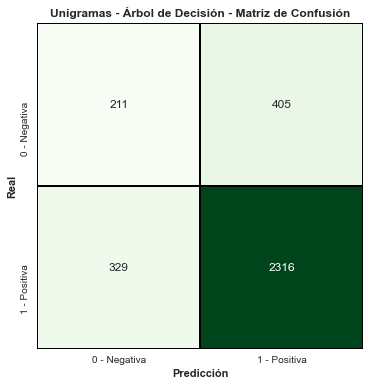

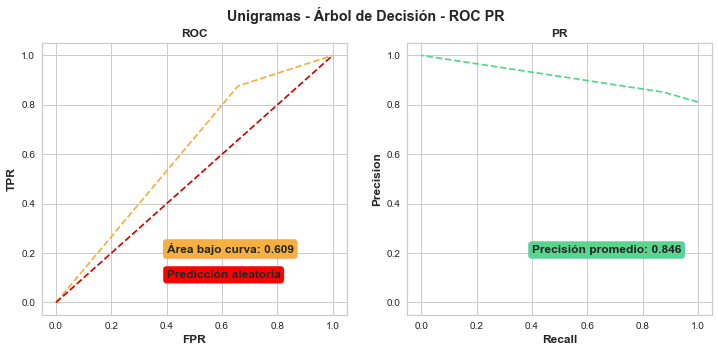

In [ ]:
# Informar resultados
informar_resultados(y_test, y_test_pred_arbolD, y_test_pred_arbolDp[:,1], 'Unigramas - Árbol de Decisión')

### **Análisis del desempeño del modelo**

Si comparamos las métricas del presente ejercicio obtenidas con árbol de decisión con vectorización con las del del ejercicio 3.1 correspondientes a la parte 3 sin aplicar vectorización, es decir sin tener en cuenta el texto de los diálogos como entrada del modelo se observa que los valores tanto para accuracy, precision, recall y F1 presentan diferencias mínimas. Por lo que, se puede afirmar que incluir el texto vectorizado al conjunto de features inicialmente utilizado en el ejer.3.1 produce mejores mínimas en el desempeño del modelo.

En cambio, si comparamos la **matriz de confusión** entre ambas aplicaciones, sin vectorización y con vectorización, se evidencia que en el segundo caso aumenta la cantidad de positivos y negativos verdaderos, mientras que por el contrario, disminuye la cantidad de falsos positivos y falsos negativos predichos por el modelo.



### **Curva ROC Y PR.**

El área bajo la curva (AUC) ROC se emplea como la medida cuantificada de desempeño. Algunas convenciones asumen lo siguiente:




| Rango del AUC | Desempeño cuantificado | 
| ------------- | ---------------------- | 
| \[0.5\] | Aleatorio \[1\]|
|\[0.5, 0.6 ) | Malo |
| \[0.6, 0.75) | Regular|
| \[0.75, 0.9) | Bueno| 
| \[0.9, 0.97) | Muy bueno|
| \[0.97, 1) | Excelente|
              



### **Análisis de la curva ROC Y PR.**

En el gráfico anterior se observa que la curva Roc con los datos de evaluación posee un AUC (área bajo la curva) igual a 0.609, es decir, que se puede afirmar que el desempeño del modelo es regular. Si lo comparamos con el gráfico de la curva ROC del ejercicio 3.1 del la parte 3 en donde se utilizaron árboles de decisión sobre el conjunto de datos de los diálogos sin de tener el cuenta la columna `tokens` la cual contiene el texto de los diálogos, el AUC posse un valor de 0.6 lo que representa que el modelo también ha tenido un desempeño regular, por lo tanto el haber incluido el texto como una feature más en el modelado no representa mejoras significativas en el desempeño del modelo. Ambos valores de AUC fueron comparados con los valores de la tabla de convenciones anteriormente descripta.

Por otro lado, se observa que en el gráfico de la curva precisión vs. recall con datos de validación (arriba a la derecha) los valores tanto de precisión como recall son menores al valor ideal (=1),  por lo que  aumentará la tasa de falsos positivos y falsos negativos. Si comparamos la precisión promedio del presente gráfico, igual a 0.846, con la del ejercicio 3.1 de la parte 3, cuya precisión es de 0.833 se observa que aunque la mejora es mínima entre ambos, la tasa de falsos positivos y falsos negativos es menor.


## 10. Predicción usando Naive Bayes

Además del algoritmo de clasificación anteriormente utilizado, utilizaremos Naive-Bayes debido a que una de sus ventajas es la capacidad de manejo de un gran número de características o features, y en el presente caso, hay miles de palabras diferentes y cada palabra de los diálogos contenidos en las columnas`tokens_tutor` y `tokens_student` será tratada como una característica.

In [ ]:
naive_bayes = MultinomialNB(alpha=0.0, class_prior=[0.3, 0.7])
naive_bayes.fit(X_train, y_train)

MultinomialNB(alpha=0.0, class_prior=[0.3, 0.7])

#### **Predicción con el conjunto de datos de entrenamiento y test.**

In [ ]:
# a. Predicción con el conjunto de datos de train
y_train_pred_NB = naive_bayes.predict(X_train)
y_train_pred_NBp = naive_bayes.predict_proba(X_train)

# b. Predicción con el conjunto de datos de test
y_test_pred_NB = naive_bayes.predict(X_test)
y_test_pred_NBp = naive_bayes.predict_proba(X_test)

## **Evaluación del modelo**

Para evaluar Naive-Bayes con unigramas utilizaremos las siguientes métricas de desempeño:

* Accuracy
* Precision
* Recall
* F1-score
* Matriz de confusión

#### **Resultados de las métricas**

              precision    recall  f1-score   support

           0       0.40      0.51      0.45       616
           1       0.88      0.82      0.85      2645

    accuracy                           0.76      3261
   macro avg       0.64      0.66      0.65      3261
weighted avg       0.79      0.76      0.77      3261
 




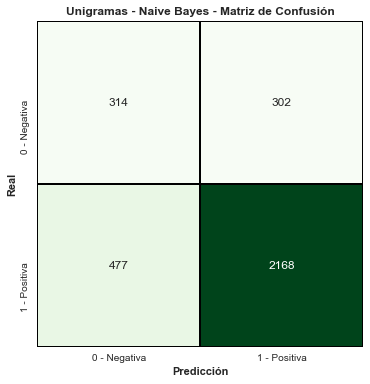

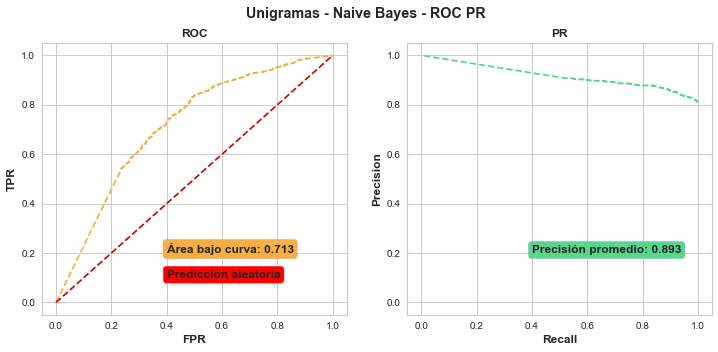

In [ ]:
# Informar resultados
informar_resultados(y_test, y_test_pred_NB, y_test_pred_NBp[:,1], Title='Unigramas - Naive Bayes')

### **Análisis de desempeño entre Árbol de decisión y Naive-bayes con vectorización**

Si comparamos los resultados obtenidos con el presente modelo y árboles de decisión se observa una mejora unicamente en **precision** ya que en el resto de las métricas el modelo de árboles tiene mejores valores, aunque cabe aclarar que las diferencías son mínimas:

|           | Árboles de Decisión | Naive-Bayes |
| ----------|-------------------  | ----------- |
| Accuracy  |  **0.77**                 | 0.76          |
| Precision | 0.85           |  **0.88**   |
| Recall    | **0.88**                | 0.82        |
| F1-score  | **0.86**                | 0.85        |
| Curva ROC | 0.609               | **0.713**       |
| Curva PR  | 0.846               | **0.893**       |
|Positivos verdaderos|  **2316**      |2168         |
| Negativos verdaderos| 211       |**314**          |
|Falsos Positivos| 405            |          **302**|
|Falsos Negativos|**329**             |           477|


Si comparamos las curvas Roc y Pr de ambos modelos, se observa que en el modelo de Naive-Bayes si bien se incrementa el valor del AUC, el mismo no representa una mejora en el desempeño ya que dicho valor continúa correspondiente al rango de desempeño regular. Por otro lado, se evidencia un aumento en el valor de la precisión promedio, lo que permite afirmar que disminuye la tasa de falsos positivos que también se evidencia en la matriz de confusión.


# Parte B: Desarrollo utilizando unicamente **tokens_tutor**
A partir de acá se trabajará utilizando unicamente el texto de la columna `tokens_tutor.`Esto se se debe a que se llevaran a cabo las siguientes ejecuciones:

a. el método de `CountVectorizer`con hiperparámetros con el texto de los tokens unificados (`tokens_tutor` + `tokens_students`) 

b. el método de `CountVectorizer`con hiperparámetros con el texto de  `tokens_tutor` 

c. el método de `CountVectorizer`con hiperparámetros con el texto de  `tokens_students`

y se obtuvieron mejores resultados de desempeño utilizando la opción b. 

## 11. Exploración de hiperparámetros de CountVectorizer

Con el objetivo de visualizar lo que hace CountVectorizer exploraremos sus hiperparámetros `min_df`, `max_df` y `ngram-range`

#### **Tokens de baja frecuencia.**

Palabras que representen menos de un 0,5 % del total de palabras de los dialógos.

In [ ]:
# palabras que representen menos de un 0,5% de las palabras totales
vectorizer_min = CountVectorizer(min_df= 0.0, max_df= 0.005, ngram_range= (1,1))
X_min = vectorizer_min.fit_transform(df_X)

# ¿cuál es la dimensión de la matriz dispersa?
print('Dimensión de la matriz dispersa \n')
X_min.shape

Dimensión de la matriz dispersa 



(16305, 22855)

### **Visualización de los 50 tokens de menor frecuencia**

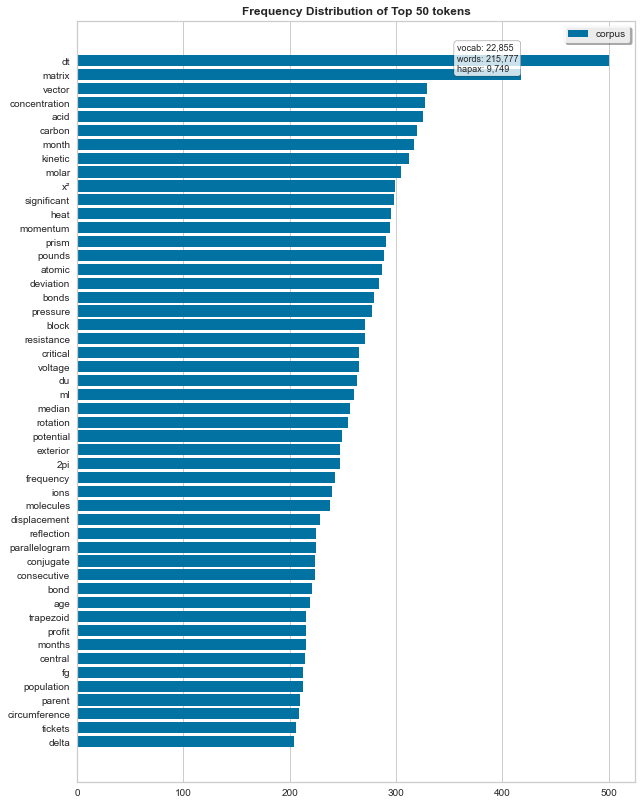

In [ ]:
plt.figure(figsize=(10,14))
features = vectorizer_min.get_feature_names()
visualizer = FreqDistVisualizer(features=features)
visualizer.fit(X_min)
visualizer.poof()

 #### **Predicción usando el clasificador Naive Bayes.**

 En el siguiente chunk se lleva a cabo el siguiente proceso:

 - el conjunto de datos es dividido en datos de entrada y en la referencia o target al cual debe apuntar el clasificador al momento de predecir.
 - se divide nuevamente al conjunto de datos en datos de entrenamiento o train y datos de evaluación o test.
 - se ajusta el modelo 
 - se realiza la predicción para ambos conjuntos 
 - se imprimen las métricas resultantes.

In [ ]:
# Predicción usando Naive Bayes
X, y = X_min, df_y     
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
naive_bayes.fit(X_train, y_train)
y_train_pred_NB = naive_bayes.predict(X_train)
y_test_pred_NB = naive_bayes.predict(X_test)

#### **Resultados de las métricas**

In [ ]:
print(classification_report(y_test, y_test_pred_NB))

              precision    recall  f1-score   support

           0       0.31      0.34      0.33       616
           1       0.84      0.83      0.84      2645

    accuracy                           0.74      3261
   macro avg       0.58      0.58      0.58      3261
weighted avg       0.74      0.74      0.74      3261



#### **Tokens de alta frecuencia**

Palabras que representen más de un 35%  del total de palabras de los dialógos.

In [ ]:
# palabras que representen más de un 35% del total de palabras
vectorizer_max = CountVectorizer(min_df= 0.35) 
#vectorizer = CountVectorizer(min_df= 0.005, max_df= 0.35)
X_max = vectorizer_max.fit_transform(df_X)
# ¿cuál es la dimensión de la matriz dispersa?
print('Dimensión de la matriz dispersa \n.')
X_max.shape

Dimensión de la matriz dispersa 
.


(16305, 111)

### **Visualización de los 50 tokens de mayor frecuencia**

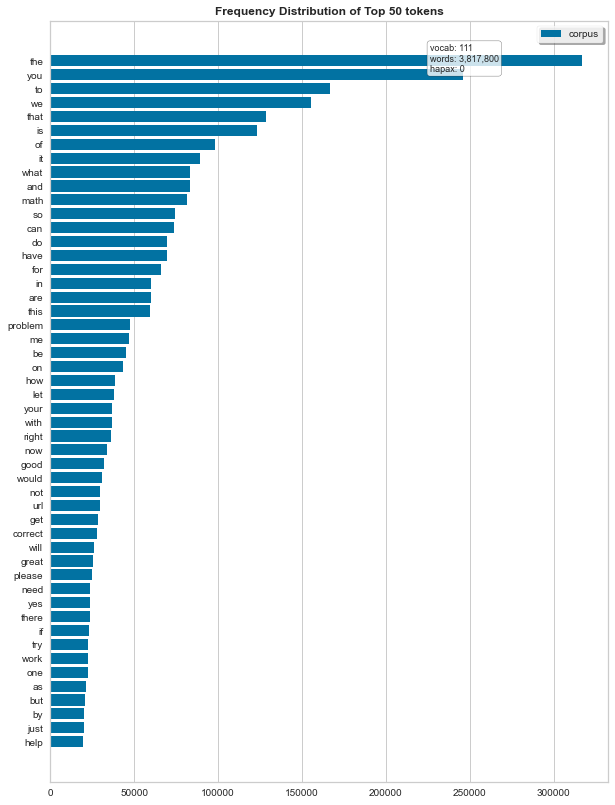

In [ ]:
plt.figure(figsize=(10,14))
features = vectorizer_max.get_feature_names()
visualizer = FreqDistVisualizer(features=features)
visualizer.fit(X_max)
visualizer.poof()

 #### **Predicción usando el clasificador Naive Bayes.**

 En el siguiente chunk se lleva a cabo el siguiente proceso:

 - el conjunto de datos es dividido en datos de entrada y en la referencia o target al cual debe apuntar el clasificador al momento de predecir.
 - se divide nuevamente al conjunto de datos en datos de entrenamiento o train y datos de evaluación o test.
 - se ajusta el modelo 
 - se realiza la predicción para ambos conjuntos

In [ ]:
# Predicción usando Naive Bayes
X, y = X_max, df_y     
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
naive_bayes.fit(X_train, y_train)
y_train_pred_NB = naive_bayes.predict(X_train)
y_test_pred_NB = naive_bayes.predict(X_test)

#### **Resultados de las métricas**

In [ ]:
# Impresión de resultados
print(classification_report(y_test, y_test_pred_NB))

              precision    recall  f1-score   support

           0       0.31      0.71      0.43       616
           1       0.90      0.63      0.75      2645

    accuracy                           0.65      3261
   macro avg       0.61      0.67      0.59      3261
weighted avg       0.79      0.65      0.69      3261



## 12. Predicción modificando los parámetros del proceso de vectorización

#### **Unigramas**

Vectorizamos unigramas excluyendo aquellos de baja frecuencia y los de frecuencia mayor a 35%

In [ ]:
vectorizer_unigrama = CountVectorizer(min_df= 0.005, max_df= 0.35, ngram_range= (1,1)) 
X_unigrama = vectorizer_unigrama.fit_transform(df_X)
print('Dimensión de la matriz dispersa \n.')
X_unigrama.shape  

Dimensión de la matriz dispersa 
.


(16305, 1593)

In [ ]:
print(vectorizer_unigrama.get_feature_names()[:20])
dict(itertools.islice(vectorizer_unigrama.vocabulary_.items(), 20))

['000', '10', '100', '1000', '11', '12', '120', '13', '14', '15', '150', '16', '17', '18', '180', '19', '1st', '20', '200', '21']


{'hey': 672,
 'am': 120,
 'looking': 833,
 'over': 996,
 've': 1520,
 'reviewed': 1193,
 'finding': 569,
 'domain': 455,
 'square': 1329,
 'root': 1202,
 'function': 609,
 'exactly': 521,
 'where': 1547,
 'stuck': 1354,
 'tried': 1463,
 'actually': 85,
 'simplify': 1286,
 'however': 689,
 'wrong': 1573,
 'show': 1270}

In [ ]:
# Predicción usando Naive Bayes
X, y = X_unigrama, df_y     
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
naive_bayes.fit(X_train, y_train)
y_train_pred_NB = naive_bayes.predict(X_train)
y_test_pred_NB = naive_bayes.predict(X_test)
y_test_pred_NBp = naive_bayes.predict_proba(X_test)

              precision    recall  f1-score   support

           0       0.38      0.62      0.47       616
           1       0.90      0.76      0.82      2645

    accuracy                           0.73      3261
   macro avg       0.64      0.69      0.65      3261
weighted avg       0.80      0.73      0.76      3261
 




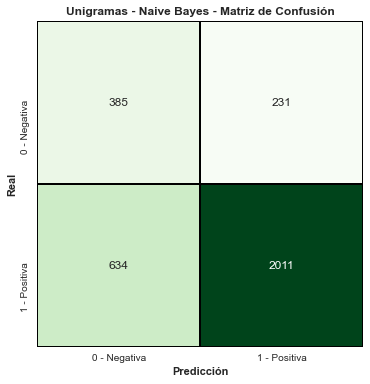

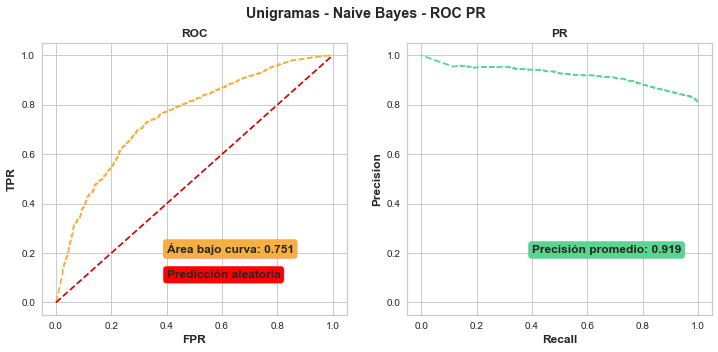

In [ ]:
informar_resultados(y_test, y_test_pred_NB, y_test_pred_NBp[:,1], Title='Unigramas - Naive Bayes')

#### **Bigramas**

En este caso, es necesario especificar el parámetro ngram_range=(2, 2).

In [ ]:
vectorizer_bigrama = CountVectorizer(ngram_range=(1, 2), min_df= 0.005, max_df= 0.35) 
X_bigrama = vectorizer_bigrama.fit_transform(df_X)
print('Dimensión de la matriz dispersa \n.')
X_bigrama.shape  

Dimensión de la matriz dispersa 
.


(16305, 8691)

In [ ]:
print(vectorizer_bigrama.get_feature_names()[2000:2020])
dict(itertools.islice(vectorizer_bigrama.vocabulary_.items(), 20))
#print('Valores del vector')
# print(X_2.toarray()) 

['factor that', 'factor the', 'factor we', 'factored', 'factored form', 'factored out', 'factoring', 'factorization', 'factorize', 'factors', 'factors are', 'factors of', 'fall', 'fall within', 'false', 'familiar', 'familiar are', 'familiar to', 'familiar with', 'fantastic']


{'hey': 2801,
 'am': 280,
 'looking': 3696,
 'over': 4826,
 've': 7732,
 'reviewed': 5483,
 'finding': 2095,
 'domain': 1669,
 'square': 6102,
 'root': 5569,
 'function': 2326,
 'exactly': 1879,
 'where': 8034,
 'stuck': 6214,
 'tried': 7398,
 'actually': 127,
 'simplify': 5903,
 'however': 2863,
 'wrong': 8330,
 'show': 5832}

In [ ]:
# Predicción usando Naive Bayes
X, y = X_bigrama, df_y     
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
naive_bayes.fit(X_train, y_train)
y_train_pred_NB = naive_bayes.predict(X_train)
y_test_pred_NB = naive_bayes.predict(X_test)
y_test_pred_NBp = naive_bayes.predict_proba(X_test)

              precision    recall  f1-score   support

           0       0.38      0.68      0.49       616
           1       0.91      0.74      0.82      2645

    accuracy                           0.73      3261
   macro avg       0.65      0.71      0.65      3261
weighted avg       0.81      0.73      0.76      3261
 




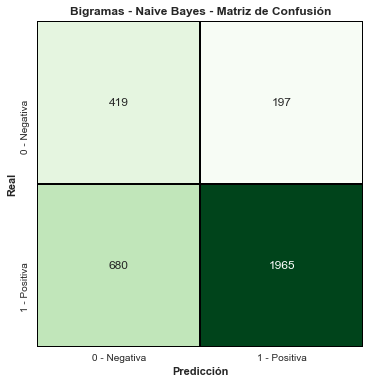

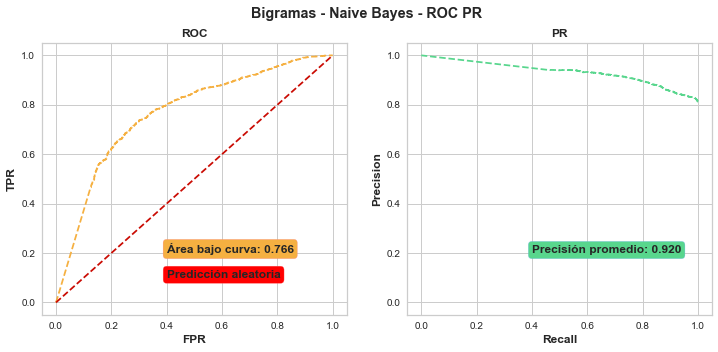

In [ ]:
informar_resultados(y_test, y_test_pred_NB, y_test_pred_NBp[:,1], Title='Bigramas - Naive Bayes')

#### **Trigramas**

En este caso, es necesario especificar el parámetro ngram_range=(3, 3).

In [ ]:
vectorizer_trigrama = CountVectorizer(ngram_range=(1, 3), min_df= 0.005, max_df= 0.35) 
X_trigrama = vectorizer_trigrama.fit_transform(df_X)
print('Dimensión de la matriz dispersa \n.')
X_trigrama.shape  #o X.shape

Dimensión de la matriz dispersa 
.


(16305, 14760)

In [ ]:
print(vectorizer_trigrama.get_feature_names()[2000:2020])
dict(itertools.islice(vectorizer_trigrama.vocabulary_.items(), 20))
#print('Valores del vector')
# print(X_2.toarray()) 

['compounds', 'compute', 'concept', 'concept clear', 'concept of', 'concept to', 'concepts', 'concepts work', 'concepts work you', 'conclude', 'conclusion', 'condition', 'confident', 'confirm', 'confirming', 'confuse', 'confuse you', 'confuse you about', 'confused', 'confused with']


{'hey': 4320,
 'am': 350,
 'looking': 5899,
 'over': 7802,
 've': 12633,
 'reviewed': 8730,
 'finding': 3137,
 'domain': 2545,
 'square': 9747,
 'root': 8877,
 'function': 3474,
 'exactly': 2815,
 'where': 13395,
 'stuck': 9892,
 'tried': 12130,
 'actually': 150,
 'simplify': 9360,
 'however': 4439,
 'wrong': 13890,
 'show': 9266}

In [ ]:
# Predicción usando Naive Bayes
X, y = X_trigrama, df_y     
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
naive_bayes.fit(X_train, y_train)
y_train_pred_NB = naive_bayes.predict(X_train)
y_test_pred_NB = naive_bayes.predict(X_test)
y_test_pred_NBp = naive_bayes.predict_proba(X_test)

              precision    recall  f1-score   support

           0       0.39      0.68      0.49       616
           1       0.91      0.75      0.82      2645

    accuracy                           0.74      3261
   macro avg       0.65      0.72      0.66      3261
weighted avg       0.81      0.74      0.76      3261
 




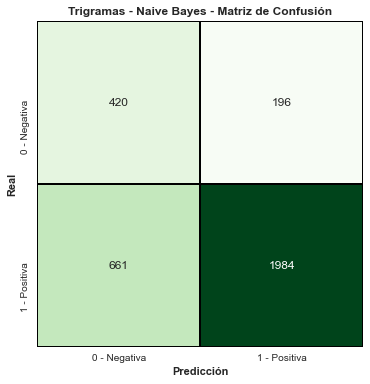

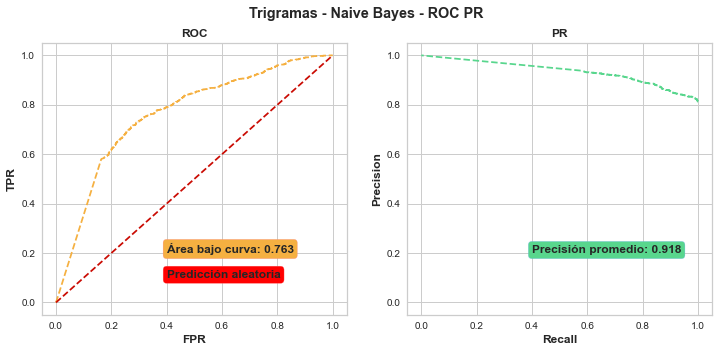

In [ ]:
informar_resultados(y_test, y_test_pred_NB, y_test_pred_NBp[:,1], Title='Trigramas - Naive Bayes')

### **Cuadro comparativo entre desempeño de Unigramas, Bigramas y Trigramas**


|           | Unigramas (Un) | Bigramas (Bi)|    Trigramas(Tri)|
| ----------|-------------------  |------| ----------- |
| Accuracy  |  0.73             | 0.73       |**0.74**|
| Precision | 0.90         | **0.91**    |**0.91**|
| Recall    | **0.76**              | 0.74        |0.75|
| F1-score  | 0.82              | 0.82        |0.82
| Curva ROC | 0.751             | **0.766**       |0.763|
| Curva PR  | **0.919**             | **0.919**       |0.918 |
|Positivos verdaderos|  **2011**    | 1965        |1984 |
| Negativos verdaderos| 385  | 419    |**420** |
|Falsos Positivos| 231       | 197   |**196** |
|Falsos Negativos|634       | 680    |**661**| 


#### **Breve análisis.**
Si comparamos las métricas de accuracy y precision del modelo utilizando unigramas, bigramas y trigramas, se evidenciar que se obtienen mejores valores con trigramas aunque la diferencia es mínima, por otro lado el mayor valor de recall se obtiene con unigramas. 
Si comparamos los valores obtenidos en las curvas ROC y PR, el mejor AUC se obtiene para bigramas con 0.766, aunque en los tres casos sus respectivos valores se encuentran comprendidos en el rango de *desempeño Bueno*. Por último, respecto a la curva PR el valor de la precisión promedio es alto para los tres casos Un, Bi y Tri y además se evidencia como disminuye levemente el número de Falsos Positivos y Falsos Negativos. 


 


*Aclaración: los valores en negrita son los mejores valores de métricas obtenidos entre los tres.*




 


 


## **13. Conclusiones de la parte B**

Luego de haber probado CountVectorizer con algunos parámetros y sobre distintos conjuntos de texto, se evidencia que usando unicamente los tokens del tutor se obtiene mejor desempeño en la detección de la clase minoritaria que usando los tokens del estudiante, e incluso que utilizando los tokens de tutores y estudiantes.

También es interesante destacar que si realizamos la predicción  utilizando unicamente tokens de alta frecuencia se logran mejores resultados en la predicción de la clase minoritaria que usando tokens de baja frecuencia.

Por último,  si se utilizan bigramas o trigramas de forma excluyente el desempeño en la detección de la clase minotritaria disminuye, sin embargo al incluir unigramas y bigramas de forma conjunta el desempeño general aumenta.

### **Referencias**

[Método CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer)

[Método TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer)



[Método TfidfTransformer()](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#sklearn.feature_extraction.text.TfidfTransformer)

[Repo sobre Applied Text Analysis with Python](https://github.com/foxbook/atap
)

Vectorización:

https://learning.oreilly.com/library/view/applied-text-analysis/9781491963036/ch04.html#ATAP04

https://learning.oreilly.com/library/view/applied-text-analysis/9781491963036/
 https://github.com/foxbook/atap/blob/master/snippets/ch04/vectorization.py

[Ejemplo de aplicación de CountVectorizer()](https://github.com/shreyans29/thesemicolon/blob/master/Text%20Analytics%20CV.ipynb)




